In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as ks

from keras.models import Sequential
from keras.layers import  Conv2D, MaxPool2D, Dropout, Dense, Flatten
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import SGD
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

In [3]:
zip_dir = ks.utils.get_file('cats_and_dogs_filterted.zip',
                            origin='https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip',
                            extract=True)

In [4]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

### Loading an images and building a datasets

In [5]:
batch_size, image_size = 128, 200

train_image_generator = ks.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  rotation_range=40,
                                                                  width_shift_range=0.2,
                                                                  height_shift_range=0.2,
                                                                  shear_range=0.2,
                                                                  zoom_range=0.2,
                                                                  horizontal_flip=True,
                                                                  fill_mode='nearest')

validation_image_generator = ks.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data_generator = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                                 directory=train_dir,
                                                                 shuffle=True, 
                                                                 target_size=[image_size,image_size],
                                                                 class_mode='binary')

validation_data_generator = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                                           directory=validation_dir,
                                                                           shuffle=True, 
                                                                           target_size=[image_size,image_size],
                                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
# load image function with keras load_img / img_to_array
def load_image(path: str, size: list = [200,200]) -> np.ndarray:
    img = load_img(path, target_size=size)
    return img_to_array(img).reshape(1,*size,3)

In [9]:
selfmade_model = Sequential()
selfmade_model.add(Conv2D(32,(3,3), activation='relu', input_shape=(image_size,image_size,3)))
selfmade_model.add(MaxPool2D(2,2))
selfmade_model.add(Conv2D(64,(3,3), activation='relu'))
selfmade_model.add(MaxPool2D(2,2))
selfmade_model.add(Conv2D(128,(3,3), activation='relu'))
selfmade_model.add(MaxPool2D(2,2))
selfmade_model.add(Conv2D(128,(3,3), activation='relu'))
selfmade_model.add(MaxPool2D(2,2))
selfmade_model.add(Dropout(0.5))
selfmade_model.add(Flatten())
selfmade_model.add(Dense(512, activation='relu'))
selfmade_model.add(Dense(2, activation='softmax'))

selfmade_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
selfmade_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 128)       1

In [10]:
epochs = 10
history = selfmade_model.fit(train_data_generator,
                             epochs=epochs,
                             steps_per_epoch=10,
                             validation_data=validation_data_generator,
                             validation_steps=10)

Epoch 1/10
10/10 [==============================] - 310s 31s/step - loss: 0.7573 - accuracy: 0.5010 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 2/10
10/10 [==============================] - 250s 25s/step - loss: 0.6932 - accuracy: 0.4970 - val_loss: 0.6921 - val_accuracy: 0.5290
Epoch 3/10
10/10 [==============================] - 240s 24s/step - loss: 0.6942 - accuracy: 0.4980 - val_loss: 0.6912 - val_accuracy: 0.5000
Epoch 4/10
10/10 [==============================] - 203s 20s/step - loss: 0.6946 - accuracy: 0.5210 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 5/10
10/10 [==============================] - 199s 20s/step - loss: 0.6937 - accuracy: 0.4960 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/10
10/10 [==============================] - 175s 18s/step - loss: 0.6939 - accuracy: 0.4680 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/10
10/10 [==============================] - 177s 18s/step - loss: 0.6931 - accuracy: 0.5020 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 

In [24]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size,image_size,3))
for layer in base_model.layers:
    layer.trainable = False
flat1 = Flatten()(base_model.layers[-1].output)
output = Dense(2, activation='softmax')(flat1)
train_image_generator = ks.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  rotation_range=40,
                                                                  width_shift_range=0.2,
                                                                  height_shift_range=0.2,
                                                                  shear_range=0.2,
                                                                  zoom_range=0.2,
                                                                  horizontal_flip=True,
                                                                  fill_mode='nearest')
validation_image_generator = ks.preprocessing.image.ImageDataGenerator(rescale=1./255)

model = Model(inputs=base_model.inputs, outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 5
history = model.fit(train_data_generator,
                    epochs=epochs,
                    steps_per_epoch=20,
                    validation_data=validation_data_generator,
                    validation_steps=50)

Epoch 1/5
20/20 [==============================] - 2011s 101s/step - loss: 0.4203 - accuracy: 0.7935 - val_loss: 0.2945 - val_accuracy: 0.8730
Epoch 2/5
 8/20 [===========>..................] - ETA: 12:32 - loss: 0.3238 - accuracy: 0.8600

cat:1.0 
dog:0.0


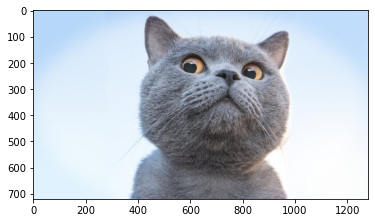

In [8]:
catdog_classifier = load_model('CatDog.h5')
answer = catdog_classifier.predict(load_image('example.jpg'))
plt.imshow(load_img('example.jpg', [250, 250]))
print(f"cat:{answer[0][0]} \ndog:{answer[0][1]}")

### Increase accuracy by retraining few layers in vgg

In [10]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        layer.trainable = True
    else:
        layer.trainable = False
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer=ks.optimizers.RMSprop(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy']);

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 19,433,793
Trainable params: 7,078,913
Non-trainable params: 12,354,880
_________________________________________________________________


In [27]:
history = model.fit(train_data_generator,
                    batch_size=128,
                    epochs=8,
                    validation_data=validation_data_generator)

Epoch 1/8
16/16 [==============================] - 1296s 81s/step - loss: 0.6222 - accuracy: 0.6830 - val_loss: 0.5201 - val_accuracy: 0.7960
Epoch 2/8
16/16 [==============================] - 1480s 92s/step - loss: 0.5344 - accuracy: 0.7675 - val_loss: 0.4293 - val_accuracy: 0.8320
Epoch 3/8
16/16 [==============================] - 1248s 78s/step - loss: 0.4624 - accuracy: 0.8030 - val_loss: 0.3596 - val_accuracy: 0.8630
Epoch 4/8
16/16 [==============================] - 1284s 80s/step - loss: 0.4125 - accuracy: 0.8325 - val_loss: 0.3179 - val_accuracy: 0.8790
Epoch 5/8
16/16 [==============================] - 1304s 82s/step - loss: 0.3829 - accuracy: 0.8390 - val_loss: 0.2771 - val_accuracy: 0.8870
Epoch 6/8
16/16 [==============================] - 1366s 85s/step - loss: 0.3469 - accuracy: 0.8545 - val_loss: 0.2478 - val_accuracy: 0.9020
Epoch 7/8
16/16 [==============================] - 1257s 79s/step - loss: 0.3275 - accuracy: 0.8540 - val_loss: 0.2274 - val_accuracy: 0.9100
Epoch 

In [35]:
#save the model with weights
model.save('cat_or_dog_model.h5')

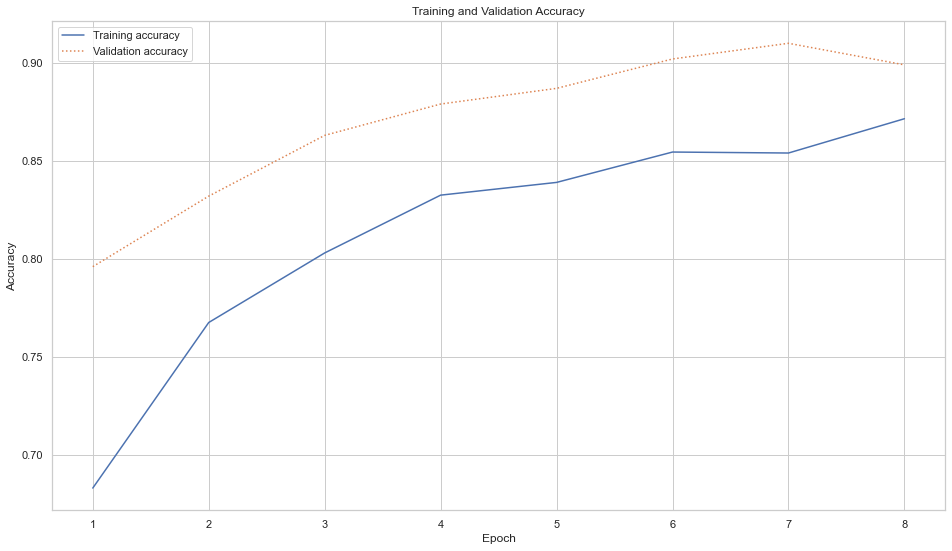

In [33]:
import seaborn as sns

plt.rc("font", size=14)
plt.figure(figsize=(16,9))
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

acc = history.history['accuracy']
val = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.plot();

In [6]:
model = load_model('cat_or_dog_model.h5')
scores = model.evaluate(validation_data_generator, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 89.90%


In [58]:
!curl -o 'example_2.jpg' 'https://static.toiimg.com/photo/msid-67586673/67586673.jpg'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  763k  100  763k    0     0   986k      0 --:--:-- --:--:-- --:--:--  985k


It is a cat


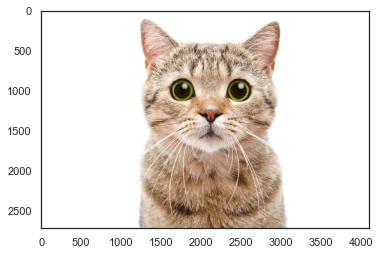

In [26]:
sns.set(style="white")
pic_name = 'example_2.jpg'
catdog_classifier = model
answer = catdog_classifier.predict(load_image(pic_name))
plt.imshow(load_img(pic_name, [250,250]))
print('It is a', 'dog' if answer[0] else 'cat')

In [62]:
selfmade_model = load_model('CatDog.h5')
layers_outputs = []
for layer in selfmade_model.layers:
    if layer.name.find('conv') != -1:
        layers_outputs.append(layer.output)
activation_model = ks.models.Model(inputs=selfmade_model.input, outputs=layers_outputs)

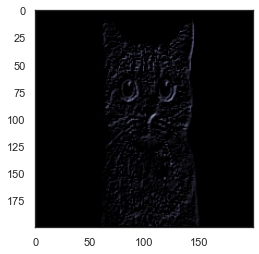

In [85]:
img = load_image(pic_name)
activations = activation_model.predict(np.array(img))
first_activations = activations[0]
plt.imshow(first_activations[0,:,:,30], cmap='bone');